GRUPO 04

*   Renan Cavalcante, 
*   Amanda Audi, 
*   Larissa Sayuri, 
*   Ingridy Silva, 
*   Vinícius Marques





In [144]:
# Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns             # heatmap
import matplotlib.pyplot as plt   # heatmap
import altair as alt              # histograma e scatterplot
from plotnine import *            # scatterplot

In [2]:
# Fazendo a conexao com o google drive (aula Mineracao)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Lendo os dados

path = "/content/drive/My Drive/INSPER/02_sem/Inf_Causal/Trabalho/dados/" 

arq_desp = "despesas_2020_abridged.txt"
arq_pref = "prefeitos_2020_abridged.txt"
arq_res = "results_2020_abridged.txt"

desp = pd.read_csv(path + arq_desp, delimiter = ',', encoding = 'latin1', decimal = ".")
pref = pd.read_csv(path + arq_pref, delimiter = ',', encoding = 'latin1', decimal = ".")
res = pd.read_csv(path + arq_res, delimiter = ',', encoding = 'latin1', decimal = ".")

numlin_ini_desp = len(desp)
numlin_ini_pref = len(pref)
numlin_ini_res = len(res)

Olhadinha Básica nos Dados

In [ ]:
# Despesa
desp.head(7)

In [ ]:
# Prefeito
pref.head(7)

In [ ]:
# Resultados
res.head(7)

In [7]:
# Total das despesas por candidato
desp_cand = desp.groupby(['cpf_cand', 'nome_cand', 'uf', 'partido'], as_index = False).agg({"valor": "sum"})
desp_cand.sort_values(by = "valor", ascending = True)

,cpf_cand,nome_cand,uf,partido,valor
17482,93357990091,CRISTIANO LUIZ LEITE,RS,PRTB,3.00
10926,42667879015,ELISA MARA ROCKE DE SOUZA,RS,PTB,5.00
4469,7437510278,WALTER LIMA NOGUEIRA,AM,PT,6.50
5547,10704493500,MARIZA CORREIA SANTOS MARTINS,BA,REPUBLICANOS,14.00
5326,9867774809,CARLOS ALBERTO DE SOUZA,SP,PRTB,14.00
...,...,...,...,...,...
7265,21091897387,JOSE SARTO NOGUEIRA MOREIRA,CE,PDT,9234942.10
1071,1475189702,EDUARDO DA COSTA PAES,RJ,DEM,9368240.68
5424,10230720412,JOAO HENRIQUE DE ANDRADE LIMA CAMPOS,PE,PSB,10502666.38
17259,91322898553,BRUNO SOARES REIS,BA,DEM,12226479.18


In [8]:
# Total de despesas por partido e UF
desp_part_uf = desp.groupby(['partido', 'uf'], as_index = False).agg({"valor": "sum"})
# Divide por um milhão
desp_part_uf["valor"] = desp_part_uf["valor"]/1000000
desp_part_uf.sort_values(by = "valor", ascending = False)

,partido,uf,valor
467,PSDB,SP,81.903040
74,DEM,BA,26.267341
561,PT,SP,26.140885
426,PSD,MG,24.785426
441,PSD,SP,23.516784
...,...,...,...
703,UP,BA,0.001300
522,PSTU,CE,0.001000
168,PC do B,MT,0.000600
643,REDE,PI,0.000400


In [ ]:
# Visualização das despesas dos partidos pela uf
# Passando o dado do formato LONGO para o LARGO
desp_part_uf_unmelted = desp_part_uf.pivot(columns = 'partido', index = 'uf')
desp_part_uf_unmelted

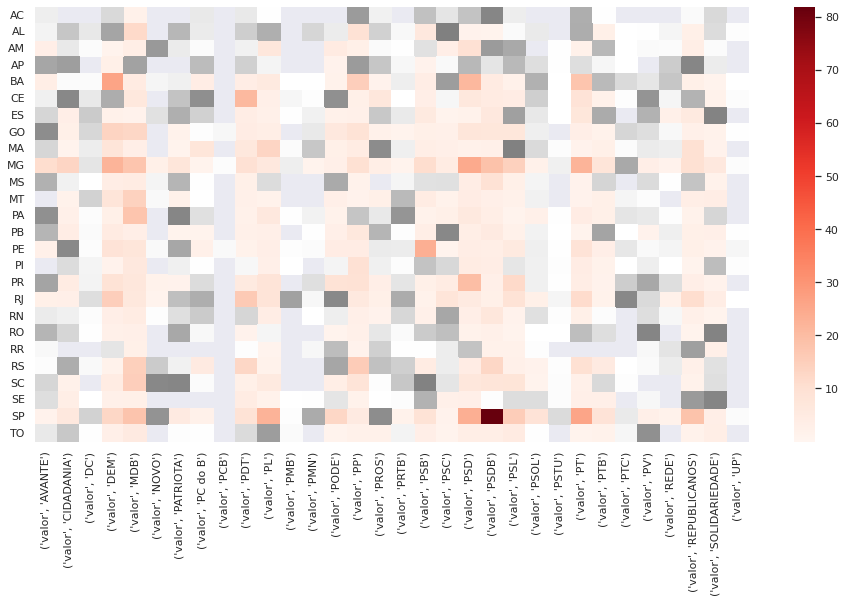

In [118]:
# Gráfico heatmap
sns.set(rc = {'figure.figsize':(16,8)})
ax = sns.heatmap(desp_part_uf_unmelted, cmap = 'Reds', annot = False)
values = desp_part_uf_unmelted.to_numpy(dtype=float)

#ax = sns.heatmap(values, cmap='Reds', vmin=0, vmax=15, square=True)
desp_part_uf_heatmap = sns.heatmap(values, 
                                   xticklabels = desp_part_uf_unmelted.columns, 
                                   yticklabels = desp_part_uf_unmelted.index,
            cmap = plt.get_cmap('binary'), vmin=0, vmax=2, mask=values > 1, cbar=False, ax=ax)


desp_part_uf_heatmap

Criando quantidades por Partido e UF

In [121]:
# Total de candidatos por Partido e UF
# Total de candidatos = Total de Municípios
tot_cand_part_uf = pref.groupby(['sigla_partido', 'sigla_uf'], as_index = False).agg({"cpf_candidato": "nunique"})
tot_cand_part_uf = tot_cand_part_uf.rename({'sigla_partido':'partido', 'sigla_uf':'uf', 'cpf_candidato': 'num_total'}, axis = 'columns')
tot_cand_part_uf.sort_values(by = "num_total", ascending = False)

,partido,uf,num_total
488,PSDB,SP,397
331,PP,RS,272
119,MDB,RS,260
107,MDB,MG,242
442,PSD,BA,241
...,...,...,...
304,PODE,RR,1
282,PMN,RR,1
281,PMN,RN,1
275,PMN,MS,1


In [122]:
# Candidatos eleitos por Partido e UF
cand_elei_part_uf = pref[pref['elected'] == 1].groupby(['sigla_partido', 'sigla_uf'], as_index = False).agg({"cpf_candidato": "nunique"})
cand_elei_part_uf = cand_elei_part_uf.rename({'sigla_partido':'partido', 'sigla_uf':'uf', 'cpf_candidato': 'num_eleito'}, axis = 'columns')
cand_elei_part_uf.sort_values(by = "num_eleito", ascending = False)

,partido,uf,num_eleito
300,PSDB,SP,173
191,PP,RS,143
77,MDB,RS,135
269,PSD,PR,128
257,PSD,BA,105
...,...,...,...
203,PROS,MT,1
201,PROS,MA,1
198,PROS,AP,1
197,PROS,AM,1


In [123]:
# Juntando as duas info
cand_part_uf = pd.merge(tot_cand_part_uf, cand_elei_part_uf, on = ["partido", "uf"], how = 'outer')
cand_part_uf.sort_values(by = "num_total", ascending = False)

,partido,uf,num_total,num_eleito
488,PSDB,SP,397,173.0
331,PP,RS,272,143.0
119,MDB,RS,260,135.0
107,MDB,MG,242,99.0
442,PSD,BA,241,105.0
...,...,...,...,...
304,PODE,RR,1,NaN
282,PMN,RR,1,NaN
281,PMN,RN,1,NaN
275,PMN,MS,1,NaN


In [124]:
# Criando uma coluna de proporção
cand_part_uf['prop_eleitos'] = round(cand_part_uf['num_eleito']/cand_part_uf['num_total'], 4)
cand_part_uf.sort_values(by = "prop_eleitos", ascending = False)

,partido,uf,num_total,num_eleito,prop_eleitos
202,PDT,AC,4,3.0,0.7500
325,PP,PI,128,83.0,0.6484
474,PSDB,MS,59,37.0,0.6271
75,DEM,AP,8,5.0,0.6250
251,PL,SE,13,8.0,0.6154
...,...,...,...,...,...
731,UP,PB,1,NaN,NaN
732,UP,PE,4,NaN,NaN
733,UP,PI,1,NaN,NaN
734,UP,RJ,1,NaN,NaN


In [125]:
# Renomeando umas colunas
res = res.rename({'sigla_partido_hoje':'partido', 'sigla_uf':'uf'}, axis = 'columns')
res.head(5)

,ano_eleicao,num_turno,uf,muni_code,partido,total_votes_race,cand_votes,max_votes,runner_up,prop_votes
1,2020,1,AC,1007,PP,7051,2311,3386,2311.0,0.3278
2,2020,1,AC,1007,PDT,7051,3386,3386,2311.0,0.4802
3,2020,1,AC,1007,PT,7051,188,3386,2311.0,0.0267
4,2020,1,AC,1007,PSB,7051,735,3386,2311.0,0.1042
5,2020,1,AC,1007,SOLIDARIEDADE,7051,431,3386,2311.0,0.0611


In [126]:
# Percentual de votos recebido por partido
res['prop_votes'] = round(res['cand_votes']/res['total_votes_race'], 4)
#res
res.sort_values(by = "prop_votes", ascending = False)

,ano_eleicao,num_turno,uf,muni_code,partido,total_votes_race,cand_votes,max_votes,runner_up,prop_votes
13016,2020,1,RS,85979,PDT,4612,4612,4612,NaN,1.0000
2029,2020,1,CE,13200,PDT,3805,3805,3805,NaN,1.0000
10004,2020,1,PI,12130,PP,7322,7322,7322,NaN,1.0000
10010,2020,1,PI,12165,PSD,3096,3096,3096,NaN,1.0000
10013,2020,1,PI,12181,MDB,3345,3345,3345,NaN,1.0000
...,...,...,...,...,...,...,...,...,...,...
1029,2020,1,BA,34436,PSL,43934,10,19634,15471.0,0.0002
8727,2020,1,PB,20516,PCO,364851,82,75610,60615.0,0.0002
3901,2020,1,MA,7617,PMB,40796,2,16846,12070.0,0.0000
8141,2020,1,PA,4812,PODE,6696,0,3348,2084.0,0.0000


PERGUNTAS

1. Uma tabela com três variáveis e as seguintes colunas: variável, média, mediana, desvio-padrão, valor mínimo (min), valor máximo (max).

In [127]:
# Métricas por UF e Partido
metrics_list = ['min', 'mean', 'median', 'max', 'std']

aux = cand_part_uf.groupby(['partido'], as_index = False).agg({'num_total': metrics_list, 
                                                         'num_eleito': metrics_list,
                                                         'prop_eleitos': metrics_list})


aux = aux.sort_values(by = ('num_eleito', 'max'), ascending = False)
aux.head(10)

partido num_total             ... prop_eleitos                  
                       min       mean  ...       median     max       std
21          PSDB         2  50.461538  ...       0.3333  0.6271  0.158883
15            PP         4  57.576923  ...       0.4000  0.6484  0.102607
4            MDB         4  75.346154  ...       0.3846  0.6000  0.118557
20           PSD         5  62.807692  ...       0.3590  0.6154  0.125831
3            DEM         2  44.346154  ...       0.4000  0.6250  0.131347
10           PDT         1  37.038462  ...       0.2875  0.7500  0.172516
18           PSB         3  33.653846  ...       0.2222  0.4771  0.097901
26           PTB         1  30.240000  ...       0.2581  0.4054  0.090920
0         AVANTE         1  18.000000  ...       0.1667  0.4000  0.123539
30  REPUBLICANOS         1  32.346154  ...       0.1909  0.4706  0.135990

[10 rows x 16 columns]

In [128]:
# Percentual de votos recebido por partido

prop_votes_part = res.groupby(['partido'], as_index = False).agg({'prop_votes':metrics_list})
#list(prop_votes_part.columns)
prop_votes_part.sort_values(by = ('prop_votes', 'min'))

partido prop_votes                                     
                         min      mean   median     max       std
12            PMB     0.0000  0.039289  0.00640  0.4871  0.105243
2              DC     0.0000  0.049709  0.01130  0.4924  0.097138
14           PODE     0.0000  0.232970  0.17700  1.0000  0.211728
22            PSL     0.0002  0.182373  0.09960  1.0000  0.189431
8             PCO     0.0002  0.000443  0.00040  0.0011  0.000299
21           PSDB     0.0003  0.392637  0.41655  1.0000  0.214377
25             PT     0.0003  0.219435  0.12955  1.0000  0.209906
17           PRTB     0.0003  0.079523  0.03130  1.0000  0.121635
31  SOLIDARIEDADE     0.0003  0.244147  0.19300  1.0000  0.214659
27            PTC     0.0003  0.055699  0.01290  0.7263  0.106543
23           PSOL     0.0004  0.033232  0.01290  0.5889  0.075635
24           PSTU     0.0004  0.005752  0.00215  0.0929  0.014425
9           PCdoB     0.0004  0.223814  0.09925  1.0000  0.234633
30   REPUBLICANOS     0.0004  0.289272  0.26770  1.0000  0.221381
7             PCB     0.0005  0.003833  0.00180  0.0132  0.004882
26            PTB     0.0005  0.327166  0.34840  1.0000  0.222708
19            PSC     0.0005  0.261495  0.24010  1.0000  0.223659
13            PMN     0.0007  0.133183  0.02420  1.0000  0.196720
32             UP     0.0007  0.007364  0.00240  0.0308  0.009353
29           REDE     0.0008  0.080252  0.02270  0.5359  0.119486
11             PL     0.0008  0.351683  0.38260  1.0000  0.214143
28             PV     0.0009  0.189816  0.08800  1.0000  0.202159
20            PSD     0.0009  0.395765  0.42560  1.0000  0.204897
6        PATRIOTA     0.0011  0.159999  0.05685  1.0000  0.200454
1       CIDADANIA     0.0012  0.290990  0.28840  1.0000  0.224280
16           PROS     0.0013  0.202315  0.10530  1.0000  0.209375
4             MDB     0.0013  0.414523  0.43540  1.0000  0.198487
0          AVANTE     0.0014  0.231343  0.14440  1.0000  0.229575
10            PDT     0.0017  0.334959  0.36670  1.0000  0.232759
15             PP     0.0025  0.424263  0.45770  1.0000  0.193850
3             DEM     0.0028  0.402041  0.42950  1.0000  0.211320
18            PSB     0.0037  0.329789  0.36330  1.0000  0.213800
5            NOVO     0.0105  0.086052  0.04620  0.5543  0.115830

2. Um histograma de uma variável contínua de alguma das bases.

In [129]:
data_prop_votes = res[['uf', 'partido', 'prop_votes']]

alt.data_transformers.disable_max_rows()

alt.Chart(data_prop_votes).mark_bar().encode(
        alt.X('prop_votes',
          title = 'Proporção de Votos'),
        alt.Y('count()',
          title = 'Frequência'))

alt.Chart(...)


*   Será que isso tá certo?
*   Não consigo achar o erro 
*   Dificuldade com o merge 


In [157]:
part_todos_votos_validos = res[res['prop_votes'] == 1]

xx = pd.merge(res, part_todos_votos_validos, on = ["muni_code"], how = "left")
#cand_part_uf_desp_part = pd.merge(cand_part_uf, desp_part_uf, on = ["partido", "uf"], how = 'outer')

xx

,ano_eleicao_x,num_turno_x,uf_x,muni_code,partido_x,total_votes_race_x,cand_votes_x,max_votes_x,runner_up_x,prop_votes_x,ano_eleicao_y,num_turno_y,uf_y,partido_y,total_votes_race_y,cand_votes_y,max_votes_y,runner_up_y,prop_votes_y
0,2020,1,AC,1007,PP,7051,2311,3386,2311.0,0.3278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,1,AC,1007,PDT,7051,3386,3386,2311.0,0.4802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020,1,AC,1007,PT,7051,188,3386,2311.0,0.0267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020,1,AC,1007,PSB,7051,735,3386,2311.0,0.1042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,1,AC,1007,SOLIDARIEDADE,7051,431,3386,2311.0,0.0611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18122,2020,2,SP,71455,PSL,291429,138201,153228,138201.0,0.4742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18123,2020,2,SP,71579,PODE,134011,67853,67853,66158.0,0.5063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18124,2020,2,SP,71579,PSDB,134011,66158,67853,66158.0,0.4937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18125,2020,2,SP,71838,MDB,142712,92770,92770,49942.0,0.6501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
part_todos_votos_validos

,ano_eleicao,num_turno,uf,muni_code,partido,total_votes_race,cand_votes,max_votes,runner_up,prop_votes
408,2020,1,AM,2038,REPUBLICANOS,5495,5495,5495,NaN,1.0
1442,2020,1,BA,36897,PCdoB,6345,6345,6345,NaN,1.0
1797,2020,1,BA,39039,PSD,14617,14617,14617,NaN,1.0
1985,2020,1,CE,13021,MDB,6304,6304,6304,NaN,1.0
2029,2020,1,CE,13200,PDT,3805,3805,3805,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...
17502,2020,1,SP,71994,PSDB,2467,2467,2467,NaN,1.0
17805,2020,1,TO,92401,PSC,1813,1813,1813,NaN,1.0
18013,2020,1,TO,96997,DEM,2555,2555,2555,NaN,1.0
18070,2020,2,RJ,58777,PL,52727,52727,52727,NaN,1.0


In [130]:
#desp_plot = desp[['uf', 'partido', 'valor']]
alt.data_transformers.disable_max_rows()
# desp_part_uf
alt.Chart(desp_cand).mark_bar().encode(
        alt.X('valor',
          title = 'Valor (R$)',
          scale = alt.Scale(type = 'log')
          #bin = alt.Bin(extent=[0, 25000000], step = 1000000)
          ),
        alt.Y('count()',
          title = 'Frequência'))

Output hidden; open in https://colab.research.google.com to view.

In [40]:
desp_part_uf.sort_values(by = "valor", ascending = False)

,partido,uf,valor
467,PSDB,SP,81.903040
74,DEM,BA,26.267341
561,PT,SP,26.140885
426,PSD,MG,24.785426
441,PSD,SP,23.516784
...,...,...,...
703,UP,BA,0.001300
522,PSTU,CE,0.001000
168,PC do B,MT,0.000600
643,REDE,PI,0.000400


In [131]:
alt.Chart(desp_part_uf).mark_bar().encode(
        alt.X('valor',
          title = 'Valor (em Milhões de R$)',
          bin = alt.Bin(extent=[0, 100], step = 10)
          ),
        alt.Y('count()',
          title = 'Frequência'))

alt.Chart(...)

In [132]:
# Excluindo os pares com despesa menor que 10 milhões
# Tipo dar um zoom
alt.Chart(desp_part_uf[desp_part_uf['valor'] > 10]).mark_bar().encode(
        alt.X('valor',
          title = 'Valor (em Milhões de R$)',
          #scale = alt.Scale(type = 'log')
          bin = alt.Bin(extent=[0, 100], step = 10)
          ),
        alt.Y('count()',
          title = 'Frequência'))

alt.Chart(...)

In [51]:
# Especificamente para o PSDB
alt.Chart(desp_part_uf[desp_part_uf['partido'] == "PSDB"]).mark_bar().encode(
        alt.X('valor',
          title = 'Valor (em Milhões de R$)',
          #scale = alt.Scale(type = 'log')
          bin = alt.Bin(extent=[0, 100], step = 2)
          ),
        alt.Y('count()',
          title = 'Frequência'))

alt.Chart(...)

In [52]:
# Especificamente para o PSDB
desp_part_uf[desp_part_uf['partido'] == "PSDB"].sort_values(by = "valor", ascending = False)

,partido,uf,valor
467,PSDB,SP,81.903040
452,PSDB,MG,18.636082
464,PSDB,RS,12.973237
453,PSDB,MS,9.356022
465,PSDB,SC,7.817873
450,PSDB,GO,7.130029
461,PSDB,RN,6.946989
449,PSDB,ES,6.179361
456,PSDB,PB,5.173791
448,PSDB,CE,4.883760


In [ ]:
# 10 maiores gastos total
# por UF

3. Uma tabela de distribuição de alguma variável discreta.

In [133]:
# Número de Candidatos (Total e Eleitos) por Partido
cand_part = cand_part_uf.groupby(['partido'], as_index = False).agg({"num_total": "sum", 
                                                                     "num_eleito": "sum"})

# Quebrando em categorias
min_tot = min(cand_part['num_total'])
max_tot = max(cand_part['num_total'])

min_el = min(cand_part['num_eleito'])
max_el = max(cand_part['num_eleito'])

cand_part['num_total_categ'] = pd.cut(x = cand_part['num_total'], bins = [min_tot-1, 50, 100, 300, 500, 1000, 1500, max_tot])
cand_part['num_eleito_categ'] = pd.cut(x = cand_part['num_eleito'], bins = [min_el-1, 50, 100, 250, 500, max_el])

cand_part

,partido,num_total,num_eleito,num_total_categ,num_eleito_categ
0,AVANTE,432,82.0,"(300, 500]","(50.0, 100.0]"
1,CIDADANIA,525,141.0,"(500, 1000]","(100.0, 250.0]"
2,DC,144,1.0,"(100, 300]","(-1.0, 50.0]"
3,DEM,1153,468.0,"(1000, 1500]","(250.0, 500.0]"
4,MDB,1959,784.0,"(1500, 1959]","(500.0, 784.0]"
5,NOVO,30,1.0,"(5, 50]","(-1.0, 50.0]"
6,PATRIOTA,437,50.0,"(300, 500]","(-1.0, 50.0]"
7,PC do B,275,46.0,"(100, 300]","(-1.0, 50.0]"
8,PCB,6,0.0,"(5, 50]","(-1.0, 50.0]"
9,PCO,35,0.0,"(5, 50]","(-1.0, 50.0]"


In [134]:
# Contando as categorias
# Já fica ordenado
cand_part.groupby('num_total_categ').count()

# Sem ordenar
# cand_part['num_total_categ'].value_counts()

,partido,num_total,num_eleito,num_eleito_categ
num_total_categ,,,,
"(5, 50]",5,5,5,5
"(50, 100]",1,1,1,1
"(100, 300]",6,6,6,6
"(300, 500]",5,5,5,5
"(500, 1000]",10,10,10,10
"(1000, 1500]",4,4,4,4
"(1500, 1959]",2,2,2,2


In [135]:
# De eleitos
cand_part.groupby('num_eleito_categ').count()

,partido,num_total,num_eleito,num_total_categ
num_eleito_categ,,,,
"(-1.0, 50.0]",16,16,16,16
"(50.0, 100.0]",3,3,3,3
"(100.0, 250.0]",6,6,6,6
"(250.0, 500.0]",4,4,4,4
"(500.0, 784.0]",4,4,4,4


4. Um gráfico de dispersão (scatterplot).

In [140]:
total = pref.groupby(['sigla_partido', 'sigla_uf'], as_index = False).agg({"cpf_candidato": "nunique"})
total

,sigla_partido,sigla_uf,cpf_candidato
0,AVANTE,AC,1
1,AVANTE,AL,6
2,AVANTE,AM,12
3,AVANTE,AP,3
4,AVANTE,BA,31
...,...,...,...
731,UP,PB,1
732,UP,PE,4
733,UP,PI,1
734,UP,RJ,1


In [141]:
psdb_uf = total.query('sigla_partido == "PSDB"')

alt.Chart(psdb_uf).mark_point().encode(
        alt.X('sigla_uf',
          title = 'estados'),
        alt.Y('cpf_candidato',
          title = 'candidatos'))

alt.Chart(...)

In [142]:
# DEM
dem_uf = total.query('sigla_partido == "DEM"')
dem_uf

,sigla_partido,sigla_uf,cpf_candidato
72,DEM,AC,2
73,DEM,AL,8
74,DEM,AM,13
75,DEM,AP,8
76,DEM,BA,95
77,DEM,CE,10
78,DEM,ES,16
79,DEM,GO,136
80,DEM,MA,38
81,DEM,MG,181


In [143]:
alt.Chart(dem_uf).mark_point().encode(
        alt.X('sigla_uf',
          title = 'estados'),
        alt.Y('cpf_candidato',
          title = 'candidatos'))

alt.Chart(...)

In [136]:
# Juntando as duas info
cand_part_uf_desp_part = pd.merge(cand_part_uf, desp_part_uf, on = ["partido", "uf"], how = 'outer')
cand_part_uf_desp_part

,partido,uf,num_total,num_eleito,prop_eleitos,valor
0,AVANTE,AC,1,NaN,NaN,0.139695
1,AVANTE,AL,6,NaN,NaN,0.101060
2,AVANTE,AM,12,1.0,0.0833,3.264534
3,AVANTE,AP,3,1.0,0.3333,0.702269
4,AVANTE,BA,31,4.0,0.1290,3.800903
...,...,...,...,...,...,...
731,UP,PB,1,NaN,NaN,0.012190
732,UP,PE,4,NaN,NaN,0.072227
733,UP,PI,1,NaN,NaN,0.022997
734,UP,RJ,1,NaN,NaN,0.001600


In [137]:
# Há correlação entre o número de candidatos eleitos (Y) e o valor total de despesas (X)?
alt.Chart(cand_part_uf_desp_part).mark_point(filled = True, size = 100).encode(
          alt.Y('num_eleito',
                title = 'Candidatos eleitos'),
          alt.X('valor',
                title = 'Valor (em R$ 1.000.000,00)'),
          color = "partido"      
).interactive()

alt.Chart(...)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 323 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


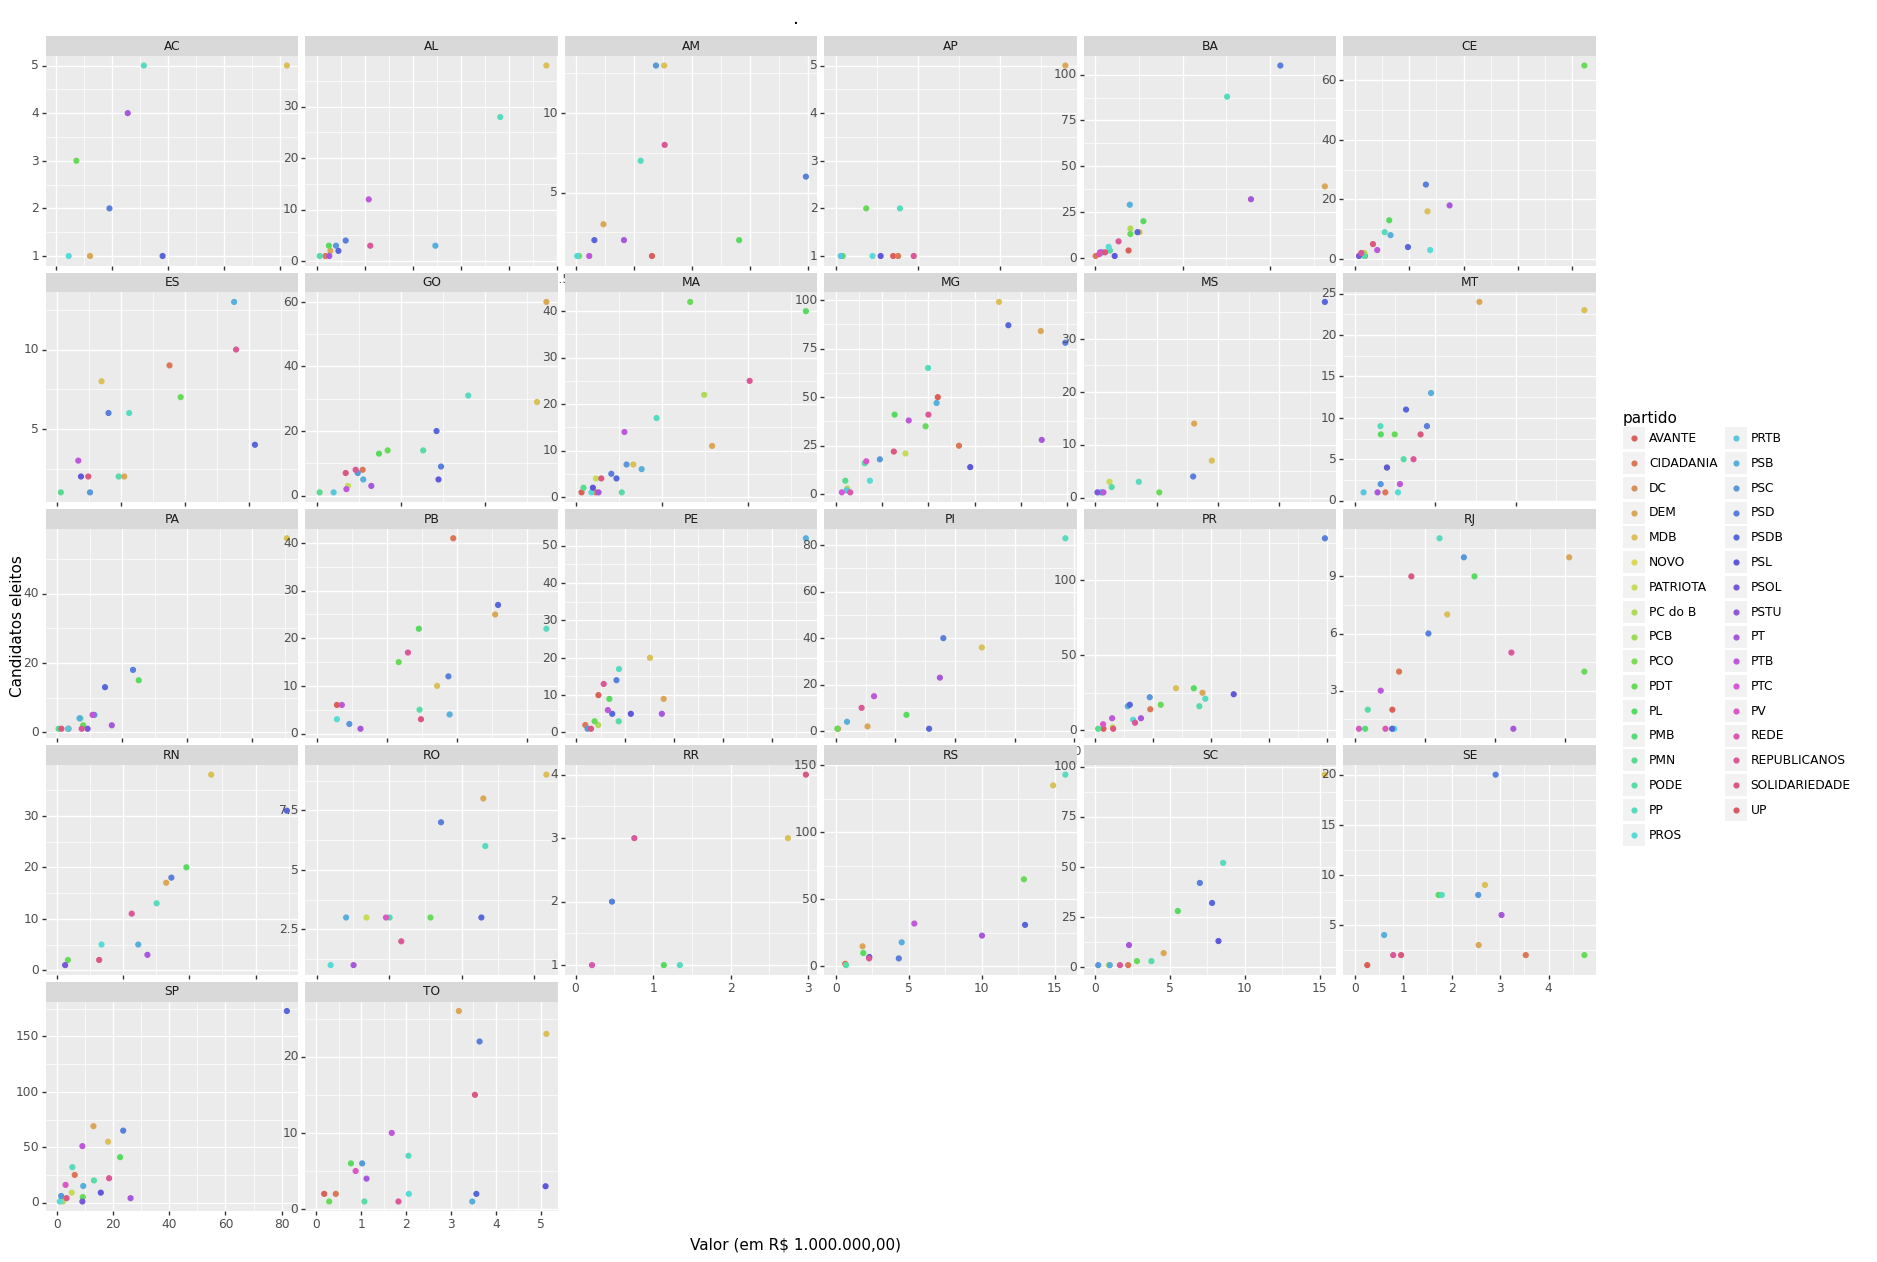

<ggplot: (8766220245157)>

In [138]:
# Há correlação entre o número de candidatos eleitos (Y) e o valor total de despesas (X) por UF?
(
ggplot(data = cand_part_uf_desp_part,
       mapping = aes(x = 'valor', y = 'num_eleito')) 
+ geom_point(aes(colour = 'partido')) 
+ facet_wrap('~ uf', scales = 'free')
+ labs(title = ".", 
       x = "Valor (em R$ 1.000.000,00)", 
       y = "Candidatos eleitos")
+ theme(figure_size = (20, 15))
)

In [139]:
cand_part_uf_desp_part['num_eleito'] = cand_part_uf_desp_part['num_eleito'].fillna(0)
cand_part_uf_desp_part

,partido,uf,num_total,num_eleito,prop_eleitos,valor
0,AVANTE,AC,1,0.0,NaN,0.139695
1,AVANTE,AL,6,0.0,NaN,0.101060
2,AVANTE,AM,12,1.0,0.0833,3.264534
3,AVANTE,AP,3,1.0,0.3333,0.702269
4,AVANTE,BA,31,4.0,0.1290,3.800903
...,...,...,...,...,...,...
731,UP,PB,1,0.0,NaN,0.012190
732,UP,PE,4,0.0,NaN,0.072227
733,UP,PI,1,0.0,NaN,0.022997
734,UP,RJ,1,0.0,NaN,0.001600


In [102]:
#cand_part_uf_desp_part[np.isfinite(cand_part_uf_desp_part["num_eleito"])]

,partido,uf,num_total,num_eleito,prop_eleitos,valor
2,AVANTE,AM,12,1.0,0.0833,3.264534
3,AVANTE,AP,3,1.0,0.3333,0.702269
4,AVANTE,BA,31,4.0,0.1290,3.800903
8,AVANTE,MA,5,1.0,0.2000,0.326706
9,AVANTE,MG,167,50.0,0.2994,11.025123
...,...,...,...,...,...,...
718,SOLIDARIEDADE,RN,27,2.0,0.0741,1.271308
720,SOLIDARIEDADE,RR,9,4.0,0.4444,2.970693
723,SOLIDARIEDADE,SE,9,2.0,0.2222,0.956722
724,SOLIDARIEDADE,SP,65,4.0,0.0615,3.300357


/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 24 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


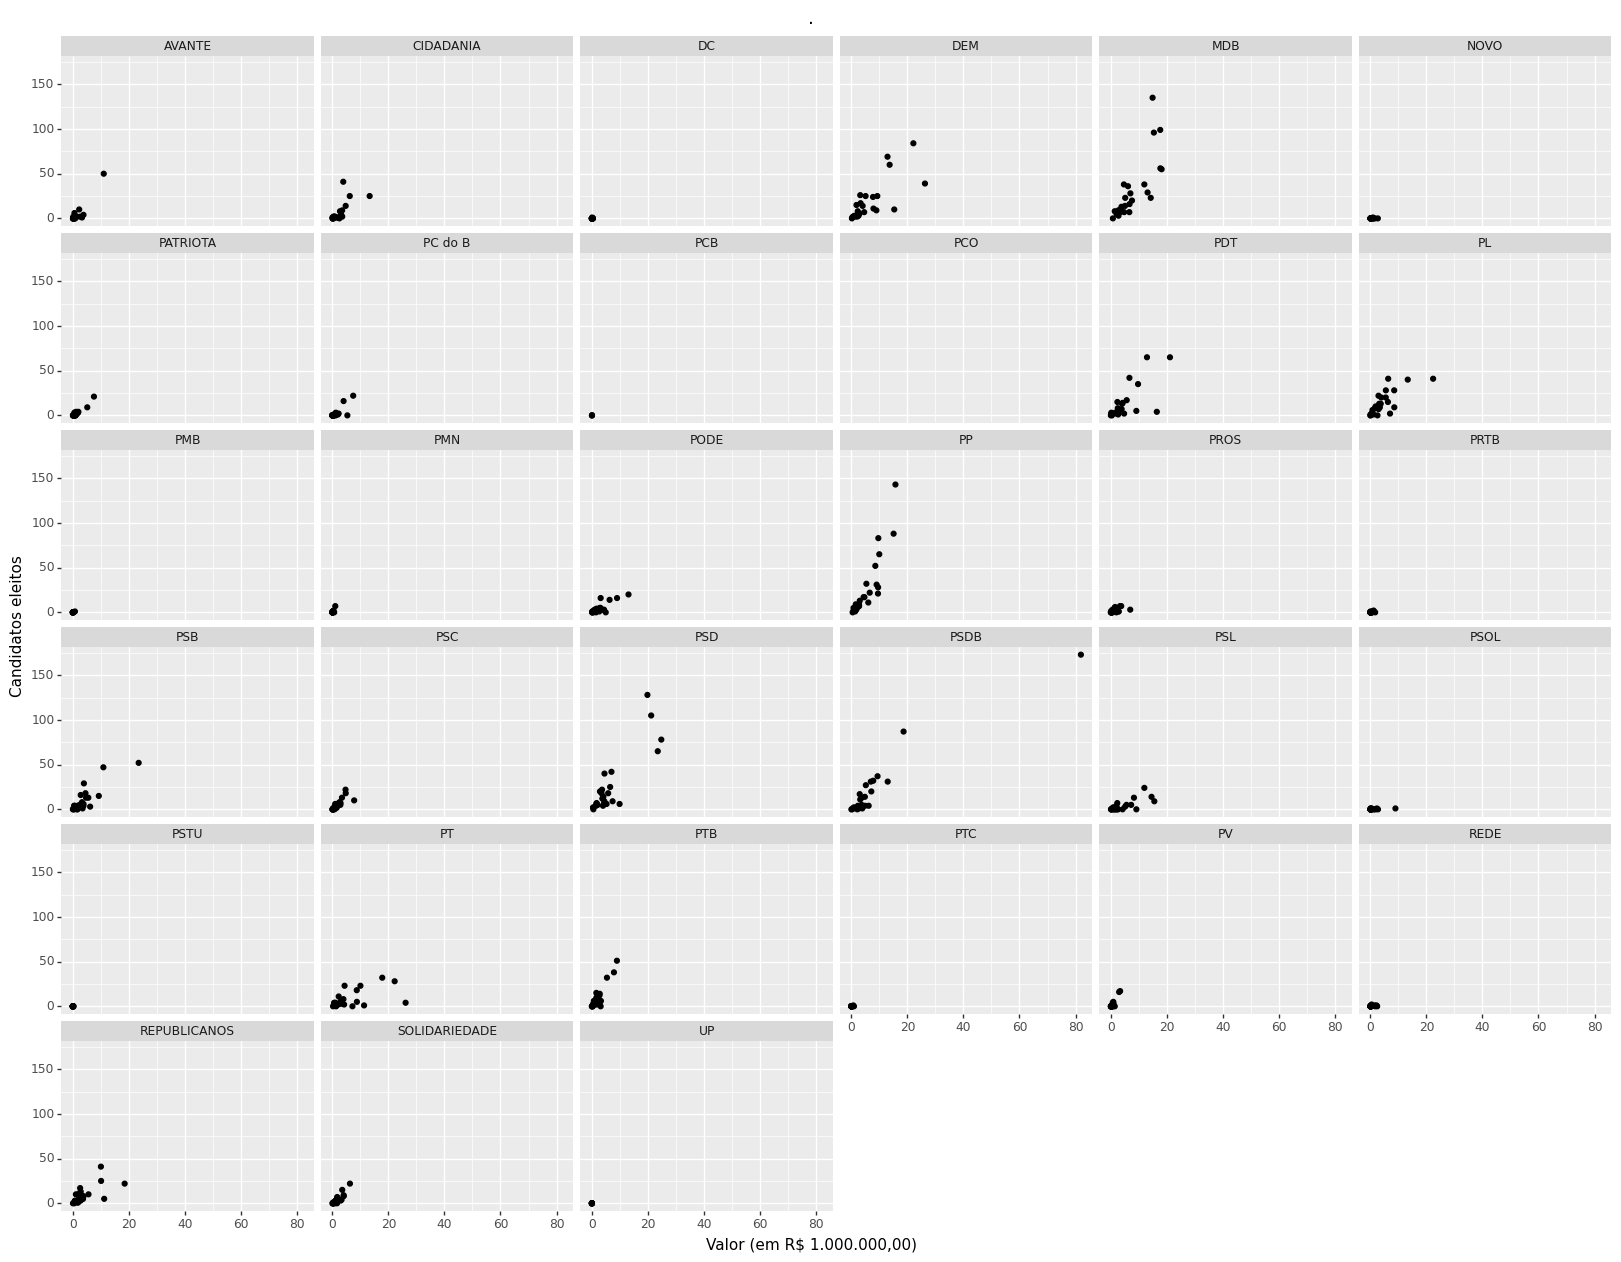

<ggplot: (8766219716901)>

In [116]:
# Há correlação entre o número de candidatos eleitos (Y) e o valor total de despesas (X) por PARTIDO?
(
ggplot(data = cand_part_uf_desp_part,
       mapping = aes(x = 'valor', y = 'num_eleito')) 
+ geom_point() 
+ facet_wrap('~ partido')
+ labs(title = ".", 
       x = "Valor (em R$ 1.000.000,00)", 
       y = "Candidatos eleitos")
+ theme(figure_size = (20, 15))
)